# TSAI

# 1) - Install & Imports

Kind of a weird process for installing libs (involves restarting runtime).

The libraries have messed up dependancy versions so need to downgrade a couple libs before installing tsai.

In [ ]:
%%script false
#@title Step 0.5 : (If errors) Run this cell only and restart runtime (and skip this on the next run)
!pip install -U protobuf==3.13
!pip install -U imgaug==0.2.6

In [2]:
#@title Step 2 : Run this cell then restart runtime
# !pip install sktime
!pip install tsai -Uq
# !pip install tsai -U >> /dev/null
# !pip install git+https://github.com/timeseriesAI/tsai.git@fdb372535 -U >> /dev/null

     |████████████████████████████████| 2.5 MB 14.0 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 


In [3]:
#@title Step 3 : Run this and all cells below
from tsai.all import *
# import tsai, fastai, fastcore, torch
# from importlib import reload; reload(tsai)

#@markdown __NOTE__ : If this import fails.. you might need to comment out a couple lines in tsai's external.py file so that it doesn't attempt to import `from sktime.utils.data_io`

print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.3.0
fastai     : 2.5.6
fastcore   : 1.4.1
torch      : 1.10.0+cu111


# 2) Load & Prep Nipams Data

In [ ]:
#@title Configure & Connect to gDrive -> Load Files

DATA_FOLDER = "/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/"
PROJECT_FOLDER = "/content/drive/My Drive/BP ML data/"
CODE_FOLDER = PROJECT_FOLDER + 'libs/'

## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
from google.colab import drive; drive.mount('/content/drive');
import sys; sys.path.insert(1, CODE_FOLDER)

from nipams_ml.imports import *
import nipams_ml as nm
nm.load.connect()

# Load Data
dfImuCont, dfBpCont = nm.load.loadFilePath(DATA_FOLDER+"*sub*/*"+"HLV"+"*.mat", drop_na=False, continuous=True, parseFileName=True)
# dfImuCont, dfBpCont = nm.load.loadFilePath(DATA_FOLDER+"*sub2*/*"+"res"+"*.mat", drop_na=False, continuous=True, parseFileName=True)

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Normalize & Interpolate Signals
# File-wise Normalize (negates different placements of sensors etc between subjects)
dfImuCont.update(dfImuCont.groupby('file').transform(lambda x : (x-x.mean())/x.std()))
# Interpolate
dfImuSamp, dfBpSamp = nm.load.interpolateDatasets(dfImuCont, dfBpCont)


In [ ]:
#@title Merge IMU and BP Datasets by TimeStamp
# https://stackoverflow.com/questions/38833362/merge-dataframes-on-nearest-datetime-timestamp
def reindex_imu(inds, df, dfRef):
  return df.reset_index().set_index(['ts']).reindex(dfRef.loc[inds].reset_index().set_index(['ts']).index, method='nearest')

dfImuSampReind = dfImuSamp.reset_index().set_index(['file','ts'])
arrdfs = []
for inds, df in dfBpSamp.groupby('file'):
  dfReind = reindex_imu(inds, df, dfImuSampReind)
  arrdfs.append(dfReind.reset_index())

dfBpSampReind = pd.concat(arrdfs)
dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'])

## Review Dataset

In [ ]:
#@title Dataset Shapes
display('--- Cont ---')
display(dfImuCont.shape, dfBpCont.shape)
display('merged', pd.merge(dfImuCont, dfBpCont, on=['file','ts']).shape)

display('--- Samp ---')
display(dfImuSamp.shape, dfBpSamp.shape)
display('merged', pd.merge(dfImuSamp, dfBpSamp, on=['file','ts']).shape)

display('--- Samp.reindex ---')
display(dfImuSampReind.shape, dfBpSamp.shape)
display('merged', pd.merge(dfImuSampReind, dfBpSamp, on=['file','ts']).shape)

'--- Cont ---'

(8021374, 10)

(14412648, 8)

'merged'

(8021374, 17)

'--- Samp ---'

(2882497, 10)

(2882605, 8)

'merged'

(336169, 17)

'--- Samp.reindex ---'

(2882497, 9)

(2882605, 8)

'merged'

(336169, 17)

In [ ]:
#@title Files/Patient Dataframe Sizes (timestamps)
display('---- dfImuSamp ----')
display(dfImuSamp.reset_index().groupby('file').ts.agg(['min','max','count']))
display('---- dfBpSamp ----')
display(dfBpSamp.reset_index().groupby('file').ts.agg(['min','max','count']))

'---- dfImuSamp ----'

,min,max,count
file,,,
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV1.mat,0 days 00:00:00,0 days 00:01:16.275000,15256
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV2.mat,0 days 00:00:00,0 days 00:01:31.015000,18204
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV3.mat,0 days 00:00:00,0 days 00:01:20.660000,16133
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub112/sub112_HLV1.mat,0 days 00:00:00.002000,0 days 00:00:42.587000,8518
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub112/sub112_HLV2.mat,0 days 00:00:00.002000,0 days 00:00:31.447000,6290
...,...,...,...
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub994/sub994_HLV2.mat,0 days 00:00:00.002000,0 days 00:01:20.952000,16191
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub994/sub994_HLV3.mat,0 days 00:00:00.002000,0 days 00:01:25.397000,17080
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub996/sub996_HLV1.mat,0 days 00:00:00.002000,0 days 00:00:52.187000,10438


'---- dfBpSamp ----'

,min,max,count
file,,,
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV1.mat,0 days,0 days 00:01:16.280000,15257
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV2.mat,0 days,0 days 00:01:31.015000,18204
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub019/sub019_HLV3.mat,0 days,0 days 00:01:20.660000,16133
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub112/sub112_HLV1.mat,0 days,0 days 00:00:42.585000,8518
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub112/sub112_HLV2.mat,0 days,0 days 00:00:31.450000,6291
...,...,...,...
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub994/sub994_HLV2.mat,0 days,0 days 00:01:20.950000,16191
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub994/sub994_HLV3.mat,0 days,0 days 00:01:25.400000,17081
/content/drive/My Drive/NiPAMS Data/2019 Nipams BP Trial/data_cleaned_LVET/sub996/sub996_HLV1.mat,0 days,0 days 00:00:52.190000,10439


# Prepare Training

In [ ]:
from tsai.imports import *
from tsai.utils import *
from tsai.data import *
# from tsai.data.validation import *
# from tsai.data.preparation import *

In [ ]:
#@title Split Data - Train & Validation
# from tsai import SlidingWindowPanel
from tsai.data.preparation import SlidingWindowPanelSplitter

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = ['sbp']
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(600, unique_id_cols=['file'], stride=200, 
                                  get_x=arrX,
                                  get_y=['sbp'])(dfReind)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()

splits = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)
X.shape, y.shape, splits

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((13965, 6, 600),
 (13965,),
 ((#11172) [3254,6105,1232,1415,3614,7535,2845,12359,8924,4130...],
  (#2793) [9470,10155,3789,7159,9924,13345,5513,1434,9640,3116...]))

## Review Training/Validation Setup

X      - shape: [13965 samples x 6 features x 600 timesteps]  type: ndarray  dtype:float32  isnan: 0
y      - shape: (13965,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [11172, 2793]  overlap: False


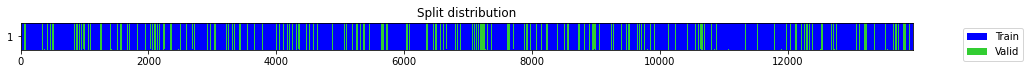

In [ ]:
#@title Review Train/Validation Splits
from tsai.data.external import check_data
check_data(X, y, splits)

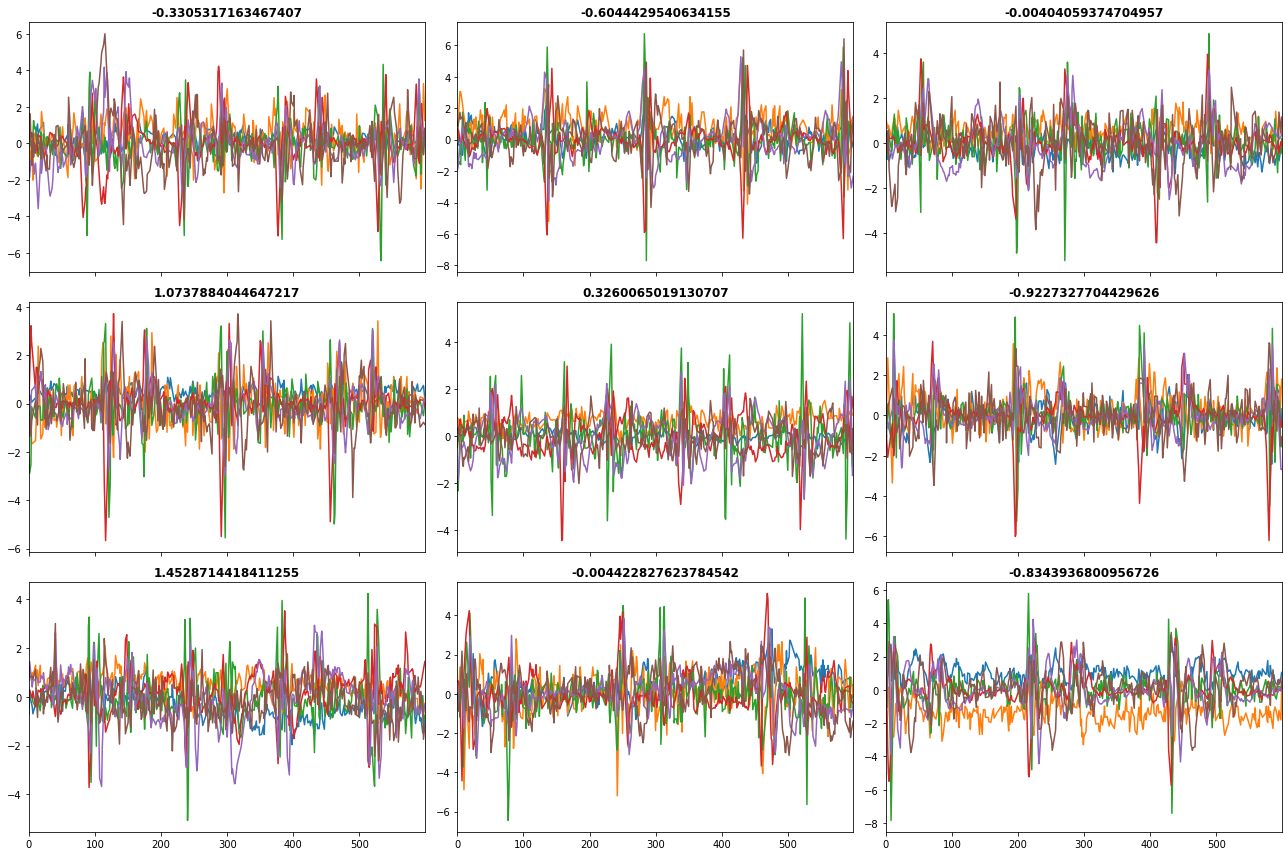

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)

# Show Batch Info
dls.one_batch()
dls.show_batch()

# Training

In [ ]:
#@title Learning Rate Finder
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
# learn.lr_find(num_it=50)

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.031088,1.046214,0.758635,1.022846,00:06
1,1.024036,1.033557,0.754290,1.016640,00:06
2,1.020006,1.011828,0.747076,1.005897,00:06
3,0.968010,0.989630,0.738276,0.994802,00:06
4,0.953783,0.955938,0.724638,0.977721,00:06
5,0.914522,0.916162,0.706034,0.957163,00:06
6,0.856042,0.865513,0.680931,0.930330,00:06
7,0.798115,0.793483,0.644341,0.890777,00:06
8,0.721468,0.692602,0.594807,0.832227,00:06
9,0.616010,0.595157,0.541466,0.771464,00:06


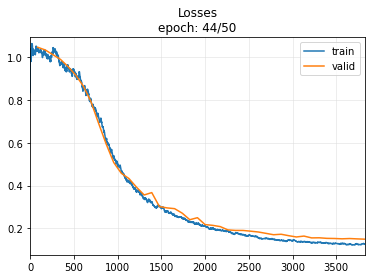

KeyboardInterrupt: ignored

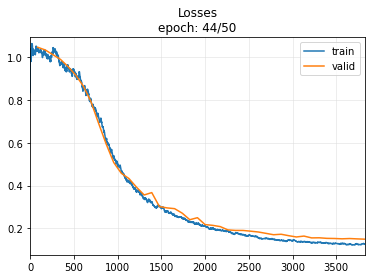

In [ ]:
#@title Run Model Training Loop
learn.fit_one_cycle(50, 1e-5)

In [ ]:
MODEL_PATH = PROJECT_FOLDER+f'models/TSAI_snapshot_{str(datetime.today().date())}.pkl'
learn.export(MODEL_PATH)
# learn = load_learner(MODEL_PATH, cpu=False)

AttributeError: ignored

# Testing & Scoring

## Scoring on Validation Set

In [ ]:
def unnorm_y(ser):
  return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits[1]])
yTarget, yPreds = unnorm_y(y[splits[1]]), unnorm_y(np.array(preds).flatten())

In [ ]:
print('RMSE', skm.mean_squared_error(yTarget, yPreds, squared=False))
print('MSE', skm.mean_squared_error(yTarget, yPreds, squared=True))
print('mean_absolute_error', skm.mean_absolute_error(yTarget, yPreds))
print('STD of Absolute Error', np.abs(yTarget - yPreds).std())
print('STD of Error', (yTarget - yPreds).std())
print('r2_score', skm.r2_score(yTarget, yPreds))

In [ ]:
dfPredsActuals = pd.DataFrame(list(zip(unnorm_y(y[splits[1]]), unnorm_y(np.array(preds).flatten()))))
display(dfPredsActuals.corr())
display(dfPredsActuals)

In [ ]:
dfPredsActuals.plot.scatter(0,1)

# Pipeline


In [ ]:
from sklearn.base import BaseEstimator

# https://scikit-learn.org/stable/developers/develop.html
class TSAI_InceptionTime(BaseEstimator):
  def __init__(self, target='sbp'):
    self.target = target

  def fit(self, X, y):
    self.y_raw = y
    
    self.learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
    self.learn.fit_one_cycle(50, 1e-5)

    return self

  def predict(self, X):

    probas, _, preds = self.learn.get_X_preds(X[splits[1]])
    yTarget, yPreds = unnorm_y(y[splits[1]]), unnorm_y(np.array(preds).flatten())
    
    return np.array(y_preds).clip(40,180)
  
  ## TODO : proper scoring method
  ## TODO : also this breaks the mvd method somehow?
  def score(self, rows, y):
    # return 1
    return np.abs((self.predict(rows))-y).fillna(0).mean()

/content


# ROUGH

In [ ]:
STOP_HERE

In [ ]:
regression_list

In [ ]:
from tsai.all import *
dsid = 'AppliancesEnergy' 
X, y, splits = get_regression_data(dsid, split_data=False)
X.shape, y.shape, y[:10]
check_data(X, y, splits)

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()
dls.show_batch()

In [ ]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()


In [ ]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(10, 1e-2)